# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step -1: Required libaries, packages

In [1]:
# Import important packages/libraries
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import csv
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from skimage import transform as transf
from sklearn.model_selection import train_test_split
import cv2
from prettytable import PrettyTable
%matplotlib inline

SEED = 22

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

training_file = 'P2_dataset/train.p'
testing_file = 'P2_dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

#To save some memory the test dataset is loaded when running prediction on those images.    
#with open(testing_file, mode='rb') as f:
#    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
#n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
_, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH = X_train.shape
image_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)


# TODO: How many unique classes/labels there are in the dataset.
with open( 'signnames.csv', 'r' ) as sign_name:
    reader = csv.reader(sign_name)
    sign_names = list(reader)

sign_names = sign_names[1::] #Remove csv header
NUM_CLASSES = len(sign_names)
print('Total number of classes: {}'.format(NUM_CLASSES) )

n_classes = len( np.unique(y_train) )
assert (NUM_CLASSES == n_classes), '1 or more class(es) not represented in training set'

n_test = len(y_test)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Total number of classes: 43
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


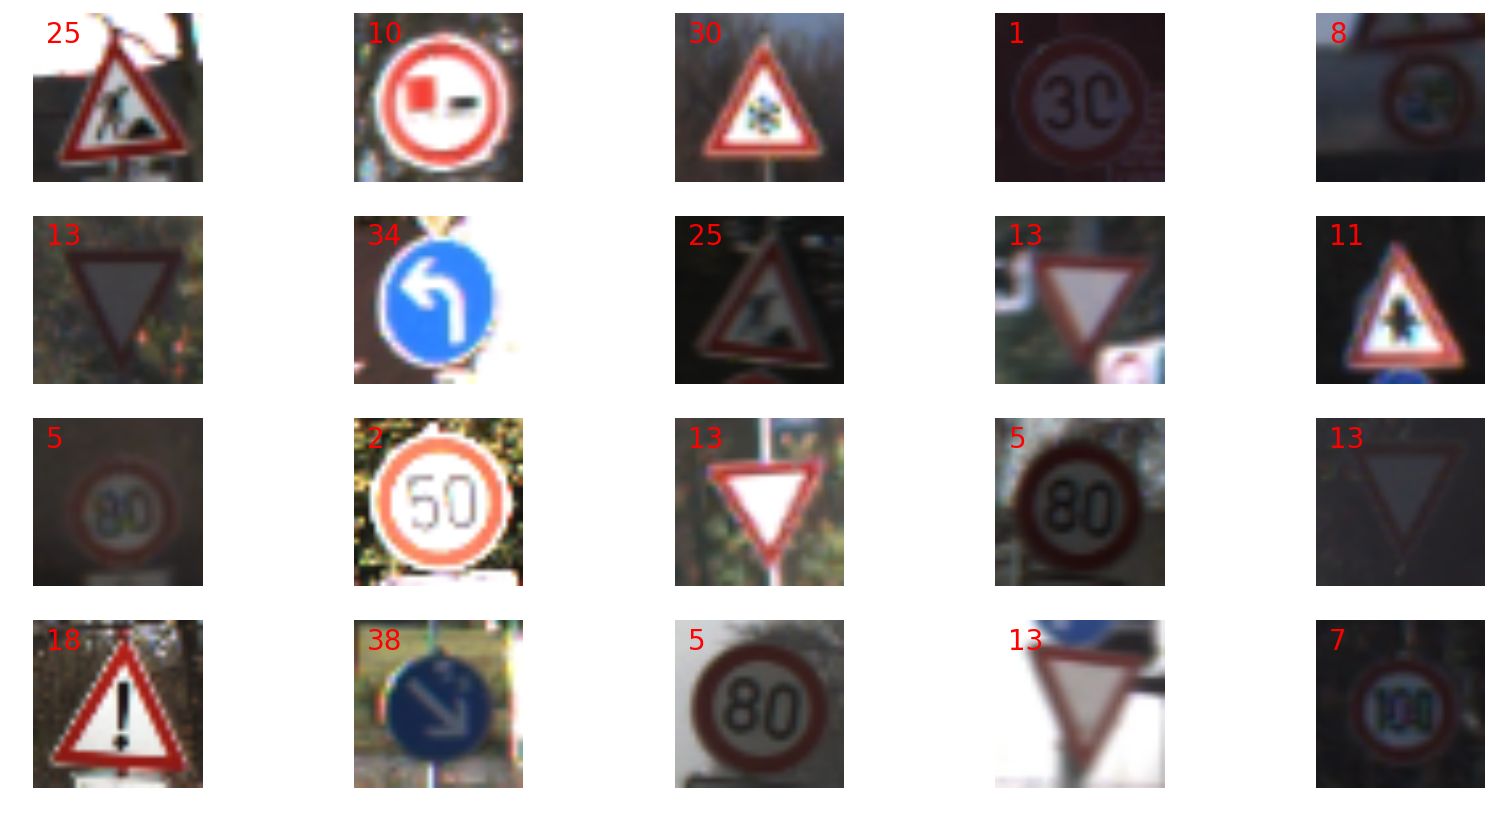

In [4]:
### DATA EXPLORATION: visualization

def visualize_random_images(list_imgs, X_dataset, y_dataset):
    '''
    list_imgs = list of index of images to be visualized
    '''
    _, ax = plt.subplots( len(list_imgs)//5, 5, figsize=(20,10))
    row, col = 0, 0  
    for idx in list_imgs:
        img = X_dataset[idx]
        ax[row, col].imshow(img)
        ax[row, col].annotate(int(y_dataset[idx]), xy=(2, 5), color='red', fontsize='20')

        ax[row,col].axis('off')
        col += 1
        if col == 5:
            row += 1
            col = 0
    plt.show()

# Visualize 20 examples picked randomly from train dataset
ls = [random.randint(0, len(y_train)) for i in range(20)]
visualize_random_images(list_imgs=ls, X_dataset=X_train, y_dataset=y_train)

------- 
Highest count: 2250.0 (class 2)
Lowest count: 210.0 (class 0)
------- 


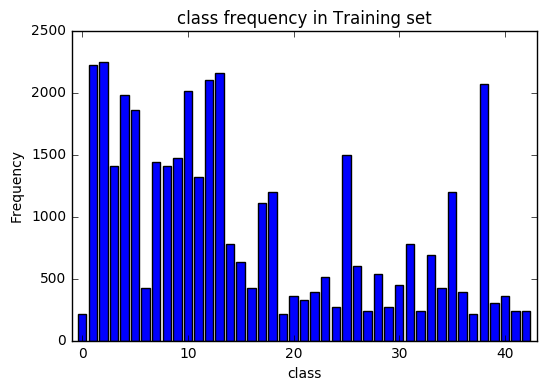

+-------------+----------------------------------------------------+
| class value |                Name of Traffic sign                |
+-------------+----------------------------------------------------+
|      0      |                Speed limit (20km/h)                |
|      1      |                Speed limit (30km/h)                |
|      2      |                Speed limit (50km/h)                |
|      3      |                Speed limit (60km/h)                |
|      4      |                Speed limit (70km/h)                |
|      5      |                Speed limit (80km/h)                |
|      6      |            End of speed limit (80km/h)             |
|      7      |               Speed limit (100km/h)                |
|      8      |               Speed limit (120km/h)                |
|      9      |                     No passing                     |
|      10     |    No passing for vechiles over 3.5 metric tons    |
|      11     |       Right-of-way

In [5]:
### DATA EXPLORATION : class distribution

assert (NUM_CLASSES == len( np.unique(y_train) )), '1 or more class(es) not represented in training set'
        
def get_count_imgs_per_class(y, verbose=False):
    num_classes = len(np.unique(y))
    count_imgs_per_class = np.zeros( num_classes )

    for this_class in range( num_classes ):
        if verbose: 
            print('class {} | count {}'.format(this_class, np.sum( y  == this_class )) )
        count_imgs_per_class[this_class] = np.sum(y == this_class )
    #sanity check
    return count_imgs_per_class


class_freq = get_count_imgs_per_class(y_train)
print('------- ')
print('Highest count: {} (class {})'.format(np.max(class_freq), np.argmax(class_freq)))
print('Lowest count: {} (class {})'.format(np.min(class_freq), np.argmin(class_freq)))
print('------- ')
plt.bar(np.arange(NUM_CLASSES), class_freq , align='center')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1, 43])
plt.title("class frequency in Training set")
plt.show()

sign_name_table = PrettyTable()
sign_name_table.field_names = ['class value', 'Name of Traffic sign']
for i in range(len(sign_names)):
    sign_name_table.add_row([sign_names[i][0], sign_names[i][1]] )
    
print(sign_name_table)

Histogram of selected images from the class 38  ......


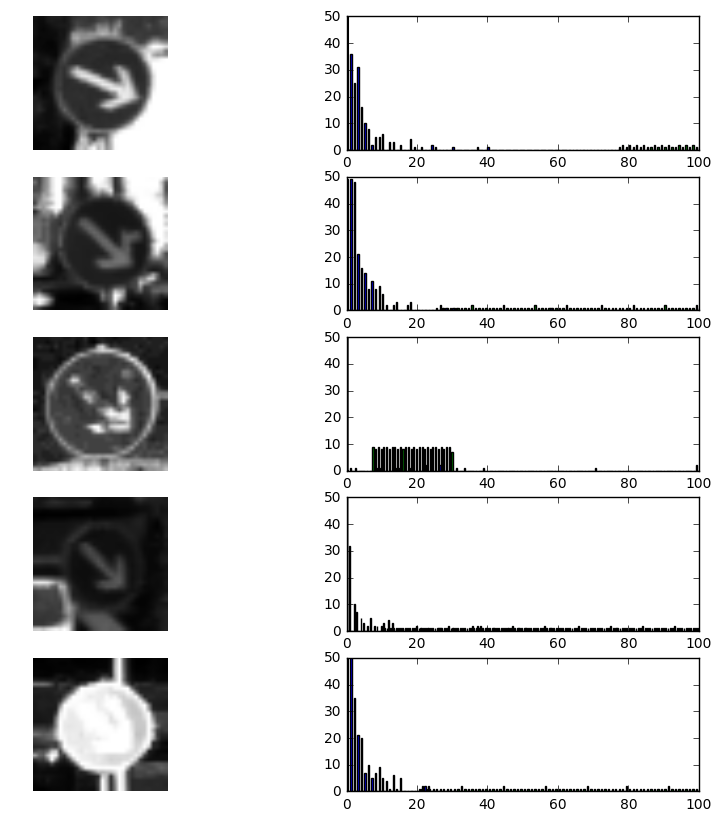

In [6]:
### DATA EXPLORATION: Pixel intensity distribution

def histograms_randImgs(label, channel, n_imgs=5, ylim=50):
    '''
    Histogram (pixel intensity distribution) for a selection of images with the same label.
    For better visualization, the images are shown in grayscale
    label - the label of the images
    n_imgs - number of images to show (default=5)
    channel - channel used to compute histogram
    ylim - range of y axis values for histogram plot (default=50)
    ''' 
    #randonly select n images
    assert channel < 3, 'images are RGB, choose channel value between in the range [0, 2]'
    assert (np.sum(y_train==label)) >= n_imgs, 'reduce your number of images'
    #find all images with the selected label
    all_imgs = np.ravel( np.argwhere(y_train==label) )
    # pick 5 images randomly
    ls_idx =  np.random.choice( all_imgs, size=n_imgs, replace=False)
    _, ax = plt.subplots( n_imgs, 2, figsize=(10,10))
    print('Histogram of selected images from the class {}  ......'.format(label))
    row, col = 0, 0  
    for idx in ls_idx:
        img = X_train[idx, :, :, channel]
        #display image
        ax[row, col].imshow(img, cmap='gray')
        ax[row,col].axis('off')
        #display histogram
        hist = np.histogram(img, bins=256)
        ax[row, col + 1].hist(hist, bins=256)
        ax[row, col + 1].set_xlim([0, 100])
        ax[row, col + 1].set_ylim([0, ylim])
        #initialize col, row value
        col = 0
        row += 1
    plt.show()

histograms_randImgs(38, 1)

### Comments:

Below are the most common variations that I noticed when comparing the images in the dataset:

1. Variation of illumination (brightness/contrast).
2. Different filling factor, i.e the size of the sign versus the image size.
3. Variation of the background scenery and color.
4. Images from the same class can have very different histogram.

Also, in the same image there are similar variations. In particular, the brightness/contrast, the background are not uniform.

The label distribution is not uniform. The "majority" classes are class 1, 2, 11, 12 which are respectively: Speed limit (30km/h), Speed limit (50km/h), Right-of-way at the next intersection and Priority road.

### Question 1 
_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

The data was pre-processed following the steps below:

1. the original dataset is splitted between the train set and the validation set in the ratio 3:1

2. Data augmentation.

3. Image conversion from RGB to grayscale

4. Data scaling
The pixel intensity of each image is scaled down to the range [-0.5, 0.5]:  x_scaled = x_original / 255 - 0.5
Each image is divided by the maximum pixel intensity available in the RGB format (255). This method enables to reduce the image pixel intensities of the dataset but any variation in the histogram from image-to-image is preserved.



5. Optionally, a histogram equalizer is applied on the grayscale images. This enables to improve the contrast in the image by broadening the distribution of the histogram.

In [7]:
def random_transform(img, angle_range=[-10, 10],
                     scale_range=[0.8, 1.2], 
                     translation_range=[-3, 3]):
    '''
    The function takes an image and performs a set of random affine transformations.
    img - original image
    ang_range - angular range of the rotation [-15,+15] deg for example
    scale_range - [0.8, 1.2]
    shear_range - [10,-10]
    translation_range : [-2, 2]
    '''
    img_height, img_width, img_depth = img.shape
    
    # Generate random parameter values
    angle_value = np.random.uniform(low=angle_range[0], high=angle_range[1], size=None)
    scaleX = np.random.uniform(low=scale_range[0], high=scale_range[1], size=None)
    scaleY = np.random.uniform(low=scale_range[0], high=scale_range[1], size=None)
    translationX = np.random.randint(low=translation_range[0], high=translation_range[1]+1, size=None)
    translationY = np.random.randint(low=translation_range[0], high=translation_range[1]+1, size=None)

    #center images to run rotation about the image center rather than [0,0] point
    center_shift = np.array( [img_height, img_width] ) / 2. -0.5
    #transformation translation of the image: image center matches [0,0] orign
    transform_center = transf.SimilarityTransform( translation = -center_shift )
    transform_uncenter = transf.SimilarityTransform( translation = center_shift )

    # Image transformation : includes rotation, shear, tranlation, zoom
    transform_aug = transf.AffineTransform( rotation = np.deg2rad( angle_value ),
                                         scale = (1/scaleY, 1/scaleX),
                                         translation = (translationY, translationX))

    # Make transformation
    full_transform = transform_center + transform_aug + transform_uncenter
    new_img = transf.warp( img, full_transform, preserve_range=True )
    
    return new_img.astype('uint8')


def data_augmentation(X_dataset, y_dataset, augm_nbr, keep_dist = True):
    '''
    X_dataset - image dataset to augment
    y_dataset - label dataset
    keep_dist - True: keep class distribution of original dataset,
                False: balance dataset,
    augm_param - is the augmentation parameter
                if keep_dist is True, increase the dataset by the factor 'augm_nbr' (2x, 5x or 10x...)
                if keep_dist is False, make all classes have same number of images: 'augm_nbr' (2500, 3000 or 4000 imgs)
    
    '''
    X_train_dtype = X_train
    n_classes = len(np.unique(y_dataset)) #number of classes in dataset
    _, img_height, img_width, img_depth = X_dataset.shape
    class_freq = get_count_imgs_per_class(y_train)
    
    if keep_dist:
        extra_imgs_per_class = np.array([augm_nbr*x for x in get_count_imgs_per_class(y_dataset)])
        
    else:
        assert (augm_nbr > np.argmax(class_freq)), 'augm_nbr must be larger than the highest class count'
        extra_imgs_per_class = augm_nbr - get_count_imgs_per_class(y_dataset) 
    
    total_extra_imgs = np.sum( extra_imgs_per_class )
    
    #if extra images needed --> run the data augmentation op 
    if total_extra_imgs > 0:
        # initialize tensor to store extra imgs, datatype same as 
        X_extra = np.zeros( ( int(total_extra_imgs), img_height, img_width, img_depth ), dtype=X_train.dtype)
        y_extra = np.zeros( int(total_extra_imgs) )
        start_idx = 0
        print('start data augmentation .....')
        for this_class in range( n_classes ):
            print('\t Class {} | Number of extra imgs {}'.format(this_class, int(extra_imgs_per_class[this_class])))
            n_extra_imgs = extra_imgs_per_class[this_class] #number of extra images to generate for this class
        
            end_idx = start_idx + n_extra_imgs
        
            if n_extra_imgs > 0:
                #get ids of all images belonging to this_class
                all_imgs_id = np.argwhere( y_dataset == this_class )
                # initialize tensor to store all the extra images for this class 
                new_imgs_x = np.zeros( ( int(n_extra_imgs), img_height, img_width, img_depth ) )
            
                for k in range( int(n_extra_imgs) ):
                    #randomly pick an original image belonging to this_class:
                    rand_id = np.random.choice( all_imgs_id[0], size=None, replace=True )
                    rand_img = X_train[rand_id]
                    #Transform image
                    new_img = random_transform( rand_img )
                    new_imgs_x[k, :, :, :] = new_img
                
                #update tensors with new images and associated labels
                X_extra[int(start_idx) : int(end_idx)] = new_imgs_x
                y_extra[int(start_idx) : int(end_idx)] = np.ones( ( int(n_extra_imgs), ) ) * this_class
                start_idx = end_idx
        return [X_extra, y_extra]
    
    else:
        return [ None, None] #similar output format as for if condition

In [8]:
# shuffle train dataset before split
X_train, y_train = shuffle(X_train, y_train)
_, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH = X_train.shape

# Split into train and validation set with ratio ~3:1
# Train/Validation split must be done before data augmentation so that validation set 
# has images similar to test set (no synthetic images)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=SEED)
print('Train set size: {} | Validation set size: {}\n'.format(X_train.shape[0], X_validation.shape[0]))

# Run data augmentation on Train set to have uniform distribution of class
X_extra, y_extra = data_augmentation(X_train, y_train, augm_nbr=4000, keep_dist = False)

Train set size: 31367 | Validation set size: 7842

start data augmentation .....
	 Class 0 | Number of extra imgs 3829
	 Class 1 | Number of extra imgs 2200
	 Class 2 | Number of extra imgs 2171
	 Class 3 | Number of extra imgs 2861
	 Class 4 | Number of extra imgs 2406
	 Class 5 | Number of extra imgs 2508
	 Class 6 | Number of extra imgs 3664
	 Class 7 | Number of extra imgs 2871
	 Class 8 | Number of extra imgs 2895
	 Class 9 | Number of extra imgs 2834
	 Class 10 | Number of extra imgs 2396
	 Class 11 | Number of extra imgs 2935
	 Class 12 | Number of extra imgs 2338
	 Class 13 | Number of extra imgs 2250
	 Class 14 | Number of extra imgs 3384
	 Class 15 | Number of extra imgs 3510
	 Class 16 | Number of extra imgs 3665
	 Class 17 | Number of extra imgs 3105
	 Class 18 | Number of extra imgs 3044
	 Class 19 | Number of extra imgs 3835
	 Class 20 | Number of extra imgs 3715
	 Class 21 | Number of extra imgs 3729
	 Class 22 | Number of extra imgs 3685
	 Class 23 | Number of extra img

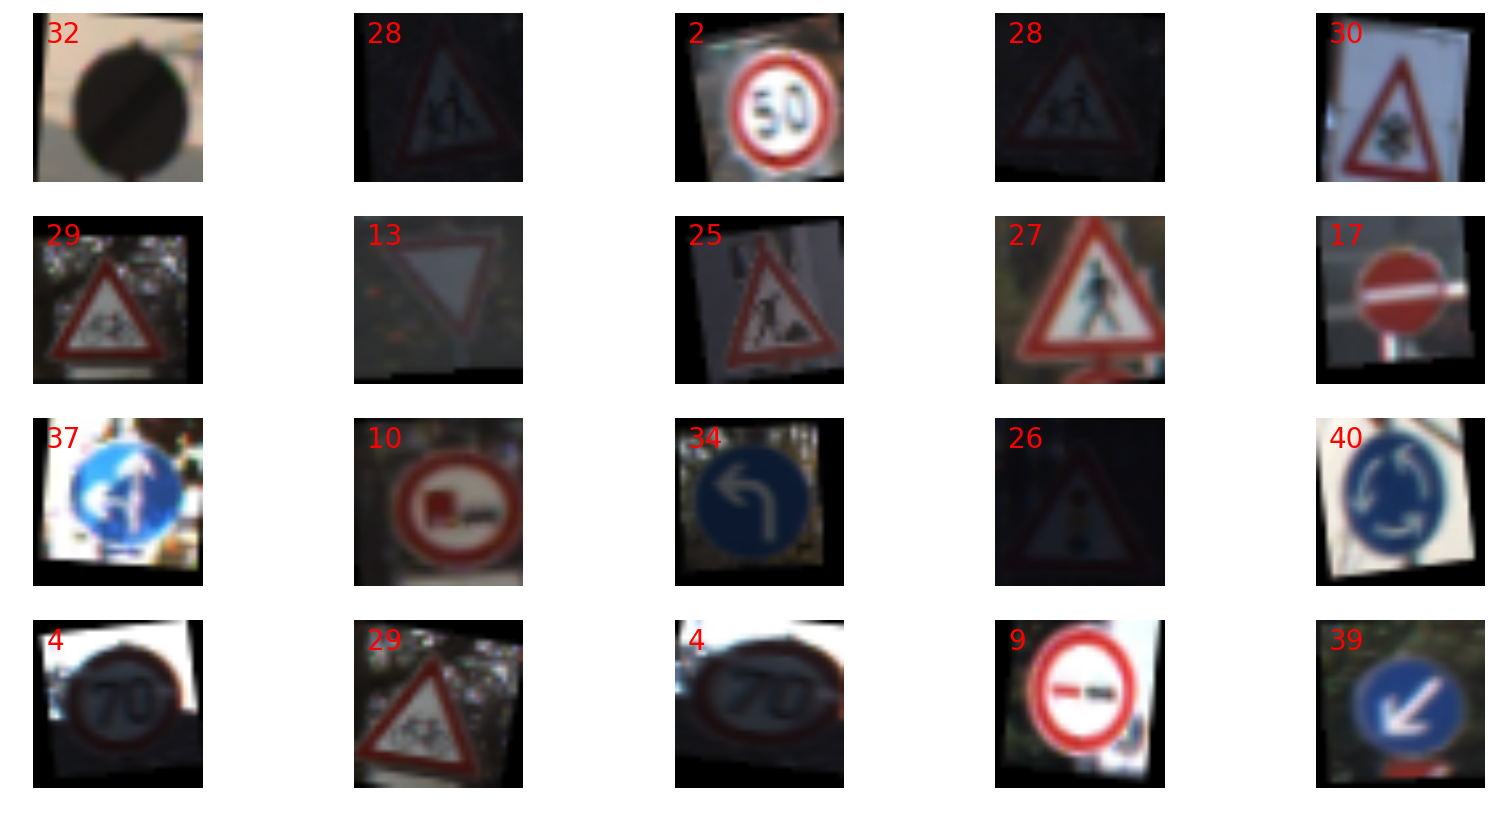

In [9]:
# Visualize 20 examples picked randomly from train dataset
ls = [random.randint(0, len(y_extra)) for i in range(20)]
visualize_random_images(list_imgs=ls, X_dataset=X_extra, y_dataset=y_extra)

In [10]:
if X_extra is not None:
    #X_extra converted to same type as X_train (original)
    # no need to shuffle data now (will be done just before it is fed to the model)
    X_train = np.concatenate( ( X_train, X_extra.astype('uint8') ), axis=0)
    y_train = np.concatenate( (y_train, y_extra), axis=0 )
    #free some space
    del X_extra, y_extra

### Visualization after data augmentation

1. Display 20 random images
2. show frequency of each class

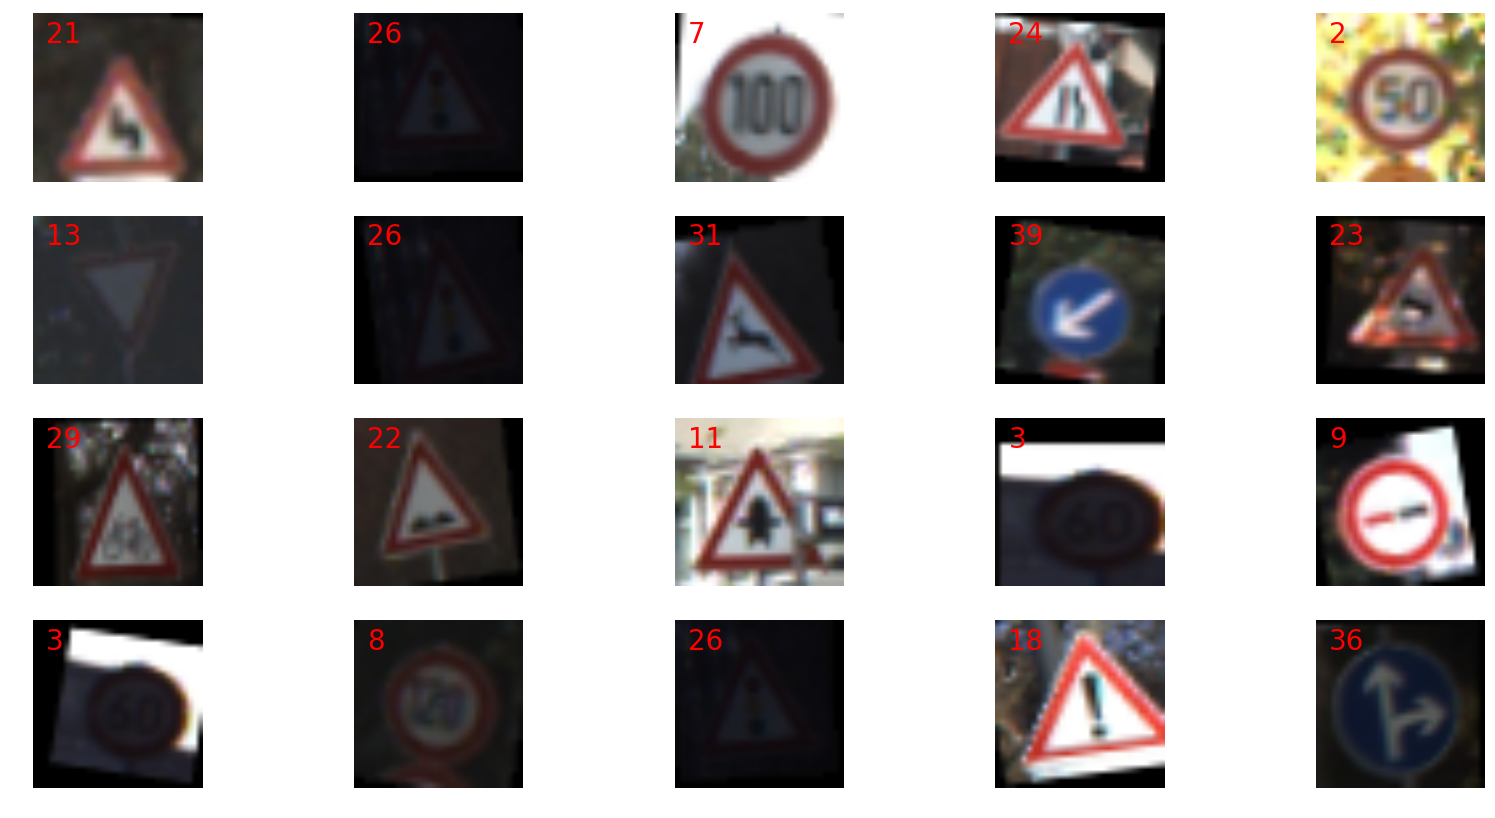

*** Train dataset after augmentation
	 Total Number of images in Train dataset: 172000


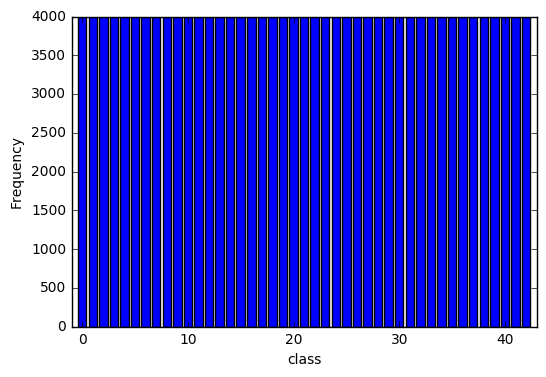

*** Validation dataset


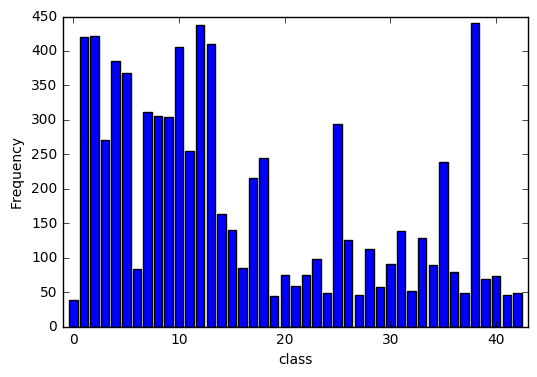

In [11]:
ls = [random.randint(0, len(y_train)) for i in range(20)]
visualize_random_images(list_imgs=ls, X_dataset=X_train, y_dataset=y_train)

print('*** Train dataset after augmentation')
print( '\t Total Number of images in Train dataset: {}'.format( X_train.shape[0] ) )

# Check data Class distribution of merged dataset (original + extra)
plt.bar( np.arange( n_classes ), get_count_imgs_per_class( y_train ), align='center' )
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1, 43])
plt.show()

# Get validation set class distribution
#Distribution very similar to that of the training set
print('*** Validation dataset')
plt.bar( np.arange( n_classes ), get_count_imgs_per_class( y_validation ), align='center' )
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1, 43])
plt.show()

In [12]:
def pre_processed(dataset):
    n_imgs, img_height, img_width, _ = dataset.shape
    processed_dataset = np.zeros((n_imgs, img_height, img_width, 1))
    for idx in range( len(dataset) ):
        img = dataset[idx]
        gray = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
        #eq= cv2.equalizeHist(gray)
        #Scaling
        #eq = eq/255.0 - 0.5
        processed_dataset[idx,:,:,0] = gray/255. - 0.5
    return processed_dataset

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1. the original dataset is splitted between the train set and the validation set in the ratio 3:1. The provided test set is not altered.
Note that the train/validation data is split before the data augmentation step. It is important that the validation set is not "contaminated" by synthetic images, i.e images generated from the data augmentation.

2. Data augmentation.
I perform data augmentation to increase the training set, but also to adjust the class distribution.
As mentionned earlier, the class distribution in the original dataset is not uniform. Because the test set might have a different class distribution than the train set, we want the model to be trained on a uniform set of data where all classes are represented equally. When trained on a skewed dataset, the model might become bias towards the classes with the highest count. After data augmentation, all the classes have same count of samples: 4000 images per class. The total number of images after data augmentation is 172000 images, and corresponds to 6X data augmentation.

The data augmentation is performed by randomly selecting images from the original dataset and then performing affine transformation: 

* rotation in the range [-10, 10] deg
I limited the angle of rotation to that 'narrow' range because the meaning of some traffic signs (like the traffic signs with arrows) can changed if the angle of rotation is too large: i.e those rotated signs could fall in another classes.
* translation along the horizontal/vertical axis: range [-3, 3] px

* scaling along the horizontal/vertical axis [0.8, 1.2]


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

In [13]:
# Variables Initialization function and Operations

def weight_variable(shape, mean, stddev, name, seed=SEED):
    init = tf.truncated_normal(shape, mean=mean, stddev=stddev, seed = SEED)
    return tf.Variable(init, name=name)
 

def bias_variable(shape, init_value, name):
    init = tf.constant(init_value, shape=shape)
    return tf.Variable(init, name=name)


def conv2d(x, W, strides, padding, name):
    return tf.nn.conv2d(x, W, strides=strides, padding=padding, name=name)


def max_2x2_pool(x, padding, name):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding=padding, name=name)

In [14]:
# Weights and biases
# Parameters

IMG_DEPTH = 1
mu = 0
sigma = 0.05
bias_init = 0.05

weights ={  
    'W_conv1': weight_variable([3, 3, IMG_DEPTH, 80], mean=mu, stddev=sigma, name='W_conv1'),
    'W_conv2': weight_variable([3, 3, 80, 120], mean=mu, stddev=sigma, name='W_conv2'),
    'W_conv3': weight_variable([4, 4, 120, 180], mean=mu, stddev=sigma, name='W_conv3'),
    'W_conv4': weight_variable([3, 3, 180, 200], mean=mu, stddev=sigma, name='W_conv4'),
    'W_conv5': weight_variable([3, 3, 200, 200], mean=mu, stddev=sigma, name='W_conv5'),
    'W_fc1': weight_variable([800, 80], mean=mu, stddev=sigma, name='W_fc1'),
    'W_fc2': weight_variable([80, 80], mean=mu, stddev=sigma, name='W_fc2'),
    'W_fc3': weight_variable([80, 43], mean=mu, stddev=sigma, name='W_fc3'),
}

biases = {
    'b_conv1': bias_variable(shape=[80], init_value=bias_init, name='b_conv1'),
    'b_conv2': bias_variable(shape=[120], init_value=bias_init, name='b_conv2'),
    'b_conv3': bias_variable(shape=[180], init_value=bias_init, name='b_conv3'),
    'b_conv4': bias_variable(shape=[200], init_value=bias_init, name='b_conv4'),
    'b_conv5': bias_variable(shape=[200], init_value=bias_init, name='b_conv5'),
    'b_fc1': bias_variable([80], init_value=bias_init, name='b_fc1'),
    'b_fc2': bias_variable([80], init_value=bias_init, name='b_fc2'),
    'b_fc3': bias_variable([43], init_value=bias_init, name='b_fc3'),
}

In [15]:
# Traffic Sign Model

def traffic_model(x, keep_prob,  k_p_conv, weights, biases):    
    '''
    ConvNet model for Traffic Sign Classifier
    x - input images is a tensor of shape (n_imgs, img_height, img_width, img_depth)
    keep_prob - hyper-parameter of the dropout operation
    weights - dictionary of the weights for convolutional layers and fully connected layers
    biases - dictionary of the biases for convolutional layers and fully connected layers
    '''
    
    # Convolutional block 1
    conv1 = conv2d(x, weights['W_conv1'], strides=[1,1,1,1], padding='VALID', name='conv1_op')
    conv1_act = tf.nn.relu(conv1 + biases['b_conv1'], name='conv1_act')
    conv1_drop = tf.nn.dropout(conv1_act, keep_prob=k_p_conv, name='conv1_drop')
    conv2 = conv2d(conv1_drop, weights['W_conv2'], strides=[1,1,1,1], padding='SAME', name='conv2_op')
    conv2_act = tf.nn.relu(conv2 + biases['b_conv2'], name='conv2_act')
    conv2_pool = max_2x2_pool(conv2_act, padding='VALID', name='conv2_pool')
    pool2_drop = tf.nn.dropout(conv2_pool, keep_prob=k_p_conv, name='conv2_drop')
    
  # Convolution block 2
    conv3 = conv2d(pool2_drop, weights['W_conv3'], strides=[1,1,1,1], padding='VALID', name='conv3_op')
    conv3_act = tf.nn.relu(conv3 + biases['b_conv3'], name='conv3_act')
    conv3_drop = tf.nn.dropout(conv3_act, keep_prob=k_p_conv, name='conv3_drop')
    conv4 = conv2d(conv3_drop, weights['W_conv4'], strides=[1,1,1,1], padding='SAME', name='conv4_op')
    conv4_act = tf.nn.relu(conv4 + biases['b_conv4'], name='conv4_act')
    conv4_pool = max_2x2_pool(conv4_act, padding='VALID', name='conv4_pool')
    conv4_drop = tf.nn.dropout(conv4_pool, keep_prob, name='conv4_drop')
    
    conv5 = conv2d(conv4_drop, weights['W_conv5'], strides=[1,1,1,1], padding='VALID', name='conv5_op')
    conv5_act = tf.nn.relu(conv5 + biases['b_conv5'], name='conv5_act')
    conv5_pool = max_2x2_pool(conv5_act, padding='VALID', name='conv5_pool')
    conv5_drop = tf.nn.dropout(conv5_pool, keep_prob, name='conv5_drop')
    
  # Fully connected layers
    fc0 = flatten(conv5_drop)
    fc1 = tf.nn.relu( tf.matmul( fc0, weights['W_fc1'] ) + biases['b_fc1'], name='fc1' )
    fc1_drop = tf.nn.dropout(fc1, keep_prob, name='fc1_drop')
    fc2 = tf.nn.relu( tf.matmul( fc1_drop, weights['W_fc2'] ) + biases['b_fc2'], name='fc2' )
    fc2_drop = tf.nn.dropout(fc2, keep_prob, name='fc2_drop')
    logits = tf.add(tf.matmul(fc2_drop, weights['W_fc3']),biases['b_fc3'], name='logits')  
    
    return [weights, logits]

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final model architecture is a ConvNet that is composed of 2 parts (see Figure below):

* 3 convolutional "blocks", where each blocks are made of 2 convolutional operations back to back. Each block ends with a max pooling operation.

* a block of fully connected layers feeding the 43 units softmax

The non-linear function is ReLU (it prevents gradient vanishing in particular for Deep Networks)

![ConvNet architecture](architecture2.png "Figure 1. Convolutional Network architecture")


* input images (32x32x1)


* **Convolutional layer 1** ===> output=(30x30x100)

 + 80 kernels of size (3x3), 'VALID' padding and stride 1

* ReLU

* **Convolutional layer 2** ===> output=(30x30x120)

 + 120 kernels of size (3x3), 'SAME' padding and stride 1

* ReLU

* Max pooling  ===> output=(15x15x120)

 + kernel (2x2) with stride 2 and 'SAME' padding


* **Convolutional layer 3** ===> output=(12x12x180)

 + 180 kernels of size (4x4), 'VALID' padding and stride 1 

* ReLU


* **Convolutional layer 4** ===> output=(12x12x200)

 + 200 kernels of size (3x3), 'SAME' padding and stride 1 

* ReLU

* Max pooling ===> output=(6x6x200)

 + (2x2) with stride 2 and 'SAME' padding
 
* **Convolutional layer 5** ===> output=(4x4x200)

 + 200 kernels of size (3x3), 'VALID' padding and stride 1 

* ReLU

* Max pooling ===> output=(2x2x200)

 + (2x2) with stride 2 and 'SAME' padding  

* Flatten ===> output: 800


* **Fully connected layer 1** ==> output: 80 units

* ReLU

* Dropout (keep rate of 0.5)


* **Fully connected layer 2** ==> output: 80 units

* ReLU

* Dropout (keep rate of 0.5)


* **softmax**  ==> output: 43 units

A less agressive **dropout** is applied to the convolutional layers.
For this categorical problem, the loss function is the cross entropy. Note that at first iteration (random weights), the loss is about 3.7, which is consistent with the expected maximum likelihood -ln(1/43)=3.76 (assuming equal probability for all classes).

In [16]:
### Train your model here.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, ( None, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH ), name='x' )
y = tf.placeholder( tf.int32, ( None ), name='y')
keep_prob = tf.placeholder( tf.float32, name='keep_prob')
k_p_conv = tf.placeholder( tf.float32, name='k_p_conv')
one_hot_y = tf.one_hot(y, n_classes )
rate = tf.placeholder( tf.float32, name='rate')

In [17]:
weights, logits = traffic_model(x, keep_prob,  k_p_conv, weights, biases)
softmax_operation = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits( logits, one_hot_y )
beta = 0.0001
loss_reg = beta * (tf.nn.l2_loss(weights['W_fc1']) + tf.nn.l2_loss(weights['W_fc2']) + tf.nn.l2_loss(weights['W_fc3']) )
loss = tf.reduce_mean( cross_entropy ) + loss_reg

optimizer = tf.train.AdamOptimizer( learning_rate = rate )
training_operation = optimizer.minimize( loss )

In [18]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    total_l = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, l = sess.run([accuracy_operation, loss], \
                               feed_dict={x: batch_x, y: batch_y,  k_p_conv:1, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
        total_l += (l * len(batch_x) )
    return [total_accuracy / num_examples, total_l/num_examples]

Training... 

Pre-processing X_train....
X_train pre-processed datatset size: (172000, 32, 32, 1) | data type: float64
End Pre-processing X_train....
EPOCH 1 ...
Train accuracy: 0.8380 | Validation Accuracy = 0.2474
Train loss: 0.71340 | Validation loss = 2.71617 

EPOCH 2 ...
Train accuracy: 0.8995 | Validation Accuracy = 0.4605
Train loss: 0.41988 | Validation loss = 1.90421 

EPOCH 3 ...
Train accuracy: 0.9285 | Validation Accuracy = 0.6163
Train loss: 0.26547 | Validation loss = 1.26394 

EPOCH 4 ...
Train accuracy: 0.9553 | Validation Accuracy = 0.7508
Train loss: 0.18220 | Validation loss = 0.90304 

EPOCH 5 ...
Train accuracy: 0.9663 | Validation Accuracy = 0.8082
Train loss: 0.12717 | Validation loss = 0.60703 

EPOCH 6 ...
Train accuracy: 0.9810 | Validation Accuracy = 0.8900
Train loss: 0.08541 | Validation loss = 0.37566 

EPOCH 7 ...
Train accuracy: 0.9882 | Validation Accuracy = 0.9309
Train loss: 0.06542 | Validation loss = 0.26346 

EPOCH 8 ...
Train accuracy: 0.9942 | V

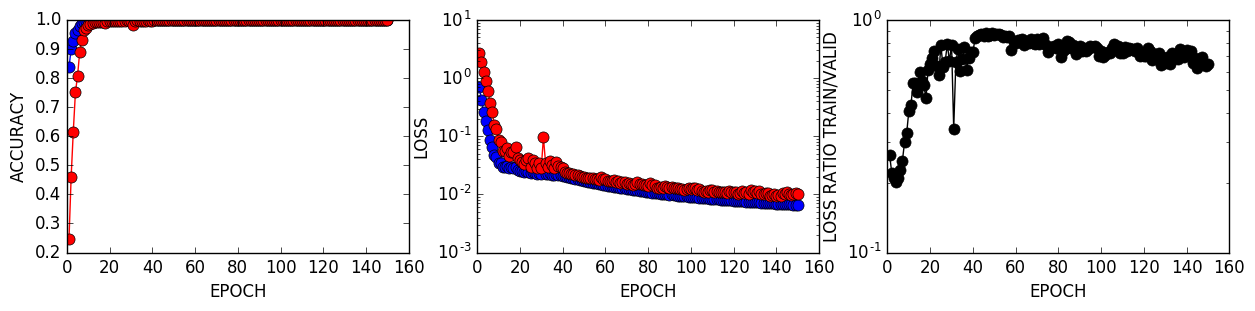

In [19]:
'''
histogram equalizer turn off
EPOCHS=60
l_rate decreases from 0.001 to l_rate/5 at 30 EPOCH and 50 EPOCHS
Keep same class distribution as original dataset: augmentation=6X
No keep prob for conv
'''

EPOCHS = 150
BATCH_SIZE = 200
model_nbr = '04c'
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training... \n")
    summary_train = []
    l_rate = 0.001
    keep_rate = 0.5
    kp_conv = 0.6

    print('Pre-processing X_train....')
    X_train_prep = pre_processed(X_train).reshape(-1, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
    X_val_prep = pre_processed(X_validation).reshape(-1, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
    print('X_train pre-processed datatset size: {} | data type: {}'.format(X_train_prep.shape, X_train_prep.dtype))
    print('End Pre-processing X_train....')    
    
    #map for reduction of l_rate at different EPOCHs (first elt)
    
    for i in range(EPOCHS):
        
        #scheme to decrease learning rate by step
        if i >= 40:
            l_rate = 0.0001
        #if i>= 90:
        #    l_rate = 0.00005

        
        X_train_prep, y_train = shuffle(X_train_prep, y_train)
        

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y =  X_train_prep[offset:end], y_train[offset:end]

            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_rate, \
                                                k_p_conv: kp_conv, rate: l_rate})

        train_accuracy, train_loss = evaluate(X_train_prep, y_train)

        validation_accuracy, validation_loss = evaluate(X_val_prep, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Train accuracy: {:.4f} | Validation Accuracy = {:.4f}".format(train_accuracy, validation_accuracy))
        print("Train loss: {:.5f} | Validation loss = {:.5f} \n".format(train_loss, validation_loss))
        summary_train.append([i+1, train_accuracy, validation_accuracy, train_loss, validation_loss])

    summary_train = np.array(summary_train)
    np.save('summary_train_'+model_nbr+'.npy', summary_train) 
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'traffic_model'+model_nbr)
    print("Model saved")

    
### Plot loss
    fig, ax = plt.subplots(1, 3, figsize=(15,3))
    plt.subplots_adjust(wspace = .2)
    # set font size tick parameters, x/y labels
    for i in range( len(ax) ):
        ax[i].tick_params(axis='x', labelsize=12)
        ax[i].tick_params(axis='y', labelsize=12)
        ax[i].xaxis.label.set_fontsize(12)
        ax[i].yaxis.label.set_fontsize(12)
    marker_size = 8
    ax[0].plot(summary_train[:,0], summary_train[:,1], 'b-o', markersize=marker_size, label='Train')
    ax[0].plot(summary_train[:,0], summary_train[:,2], 'r-o', markersize=marker_size, label='Validation')
    ax[0].set_xlabel('EPOCH')
    ax[0].set_ylabel('ACCURACY')
    ax[1].semilogy(summary_train[:,0], summary_train[:,3], 'b-o', markersize=marker_size, label='Train')
    ax[1].semilogy(summary_train[:,0], summary_train[:,4], 'r-o', markersize=marker_size, label='Validation')

    ax[1].set_xlabel('EPOCH')
    ax[1].set_ylabel('LOSS')
    ax[2].semilogy(summary_train[:,0], summary_train[:,3]/summary_train[:,4], 'k-o', markersize=marker_size, label='Train')

    ax[2].set_xlabel('EPOCH')
    ax[2].set_ylabel('LOSS RATIO TRAIN/VALID')
    
    plt.show()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**


* **Optimizer: AdamOptimizer**

* **Batch size: 200 images**
The batch size was varied from 64 to 500. I found that the validation accuracy of the Convnet decreases when the batch size was too large.

* **sigma: 0.05**
One of the parameters that affected the most the model performance was the standard deviation of the weight initializer. The weights values are initialized using a truncated Gaussian distribution with a mean of 0 and standard deviation *sigma*. If the standard deviation is too low or too high, the model will be barely learning during training. The loss would go down very slowly or not at all, and this independently of the learning rate chosen. In fact, depending on the normalization method used, the optimum sigma value may be different. 

* **learning rate: 0.001**
I had to find the right balance between a learning rate too high where at worst the model does not learn, versus a learning rate too low where the convergence is slow. The learning rate is decreased to 0.0001 at EPOCH=40, to  prevent the system to be stucked in a local minima. 

* **EPOCHS: 150**
I trained the model for 150 EPOCHS.

* **Dropout with keep rate of 0.5**
The best keep rate was 0.5 for the fully connected layer. When the keep rate was below 0.5, the learning was at best slow with a loss that decreases very slowly. The convolutional layers used also dropout but with a higher *keep_rate* of 0.6.

* ** Pooling** 
The pooling decreases the size of the output. It also prevents overfitting as a consequence of reducing number of parameters.

* ** L2 regularization**
Because the model still shows evidence of overfitting at high EPOCH (see Figure below), the L2 norm regularizer is applied to the weights of the Dense layers.

![without L2](no-l2.png "Figure 2. Loss and Accuracy of same model when the regulaizer is turned off")
The loss of the training set is 10 times smaller than that of the validation set, and the gap between the 2 loss parameters gets bigger as the number of EPOCH increases.
when adding the L2-regularizer, the ratio of [loss_train]/[loss_validation] remains practically constant (~1) at high EPOCHS.


The plots above track the accuracy and the loss of the training set and of the validation set during training. For better visualization, the y-axis is in log scale. The last plot is the ratio of the 2 losses.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

First, I implemented a shallow Neural Network with 1 convolution operation and 1 hidden fully connected layer with a few kernels and a few units for the connected layer. The model had a validation accuracy of about 85%, with a loss slightly above 1.0.

With increasing the depth and the width (the number of kernels or number of hidden nodes) of the network, the performance of the model improved significantly. The model performance was more sensitive to the depth of the Network than it was to the width.

I also included dropout and L2-regularization. Dropout was more efficient at controlling overfitting.



* Train accuracy: 100%
* Validation accuracy: 99.96%
* Test accuracy: 98.99%

The model performs better than Humans (98.81%) on this task.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [20]:
with tf.Session() as sess:
    
    loader = tf.train.import_meta_graph('traffic_model'+model_nbr+'.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    X_test_prep = pre_processed(X_test).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
    test_accuracy, _ = evaluate(X_test_prep, y_test)
    
    # select 20 random images 
    # /!\ feeding the entire X_test overflows the GPU memory for softmax_op
    ls = [random.randint(0, len(y_test)) for i in range(20)]
    X_test_select = np.zeros((20, IMG_HEIGHT, IMG_WIDTH, 1))
    y_test_select = np.zeros((20,1))
    for i in range(len(ls)):
        X_test_select[i] = X_test_prep[ls[i]]
        y_test_select = y_test[ls[i]]
        
    test_pred_proba = sess.run(softmax_operation, feed_dict={x: X_test_select,  k_p_conv:1, keep_prob: 1})
    prediction_test = np.argmax(test_pred_proba, 1)
    print("Test Accuracy = {:.4f}".format(test_accuracy))

Test Accuracy = 0.9899


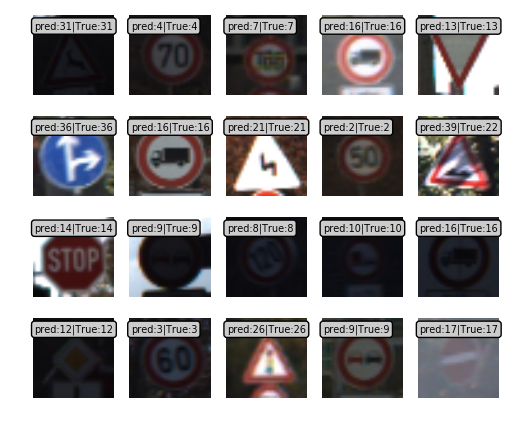

In [21]:
# VISUALIZATION
#Randonly selected images and their predicted labels

_, ax = plt.subplots( len(ls)//5, 5, figsize=(6,5))
row, col = 0, 0  
for i, idx in enumerate(ls):
    img =  X_test[idx]
    ax[row, col].imshow(img, cmap='gray')
    annot = 'pred:'+str( int(prediction_test[i])) +'|True:'+ str(y_test[idx])
    ax[row, col].annotate(annot, xy=(0, 5), color='black', fontsize='7', bbox=dict(boxstyle="round", fc="0.8"))

    ax[row,col].axis('off')
    col += 1
    if col == 5:
        row += 1
        col = 0
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

The 10 images shown below are real photos (as opposed to cliparts) of traffic signs. The images were randomly selected, that is to say that I did not look for traffic signs from a particular country. The only bias was to use real scene images, i.e where the background can be cars, trees, etc...similarly to real situation application.
Because my model was trained on German Traffic signs, it is likely that it would have difficulties classifying  class of signs that were not present in the train dataset.

In [22]:
import os

IMG_HEIGHT = 32
IMG_WIDTH = 32

def get_list_files(my_dir, f_ext):
    list_f = []
    for file in os.listdir(my_dir):
        if file.endswith("."+f_ext):
            list_f.append(file)
    return list_f

my_dir = 'extra'
file_list = get_list_files(my_dir, 'png')

X_extra = np.zeros((len(file_list), IMG_HEIGHT, IMG_WIDTH, 3), dtype='uint8')

for idx, file in enumerate(file_list):
    img = cv2.imread(my_dir+'/'+file) #opencv opens images in BGR format
    img = cv2.resize(img,(32,32))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #convert to standard RGB
    X_extra[idx] = img

print('Extra dataset size: {} | Datatype: {}'.format(X_extra.shape, X_extra.dtype))
#Data pre-processing
X_extra_prep = pre_processed(X_extra).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
print('Pre-processed Extra dataset size: {} | Datatype: {}'.format(X_extra_prep.shape, X_extra_prep.dtype))


Extra dataset size: (10, 32, 32, 3) | Datatype: uint8
Pre-processed Extra dataset size: (10, 32, 32, 1) | Datatype: float64


Original (left) and pre-processed (right) images


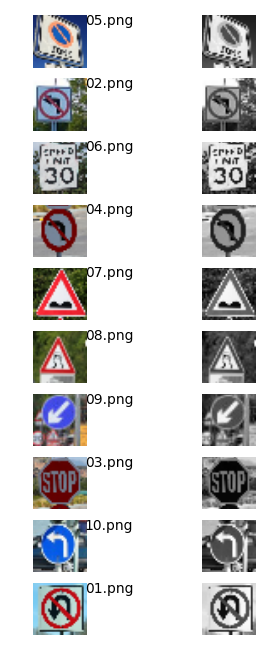

In [23]:
#Visualize images: original (left) and after pre-processing (right)

#initialize subplots
_, ax = plt.subplots( len(file_list), 2, figsize=(4,8))
col_plot = 0
print('Original (left) and pre-processed (right) images')
for i in range(len(X_extra)):
    img = X_extra[i]
    ax[i, col_plot].imshow(img)
    ax[i, col_plot].annotate(file_list[i], xy=(31, 5), color='black', fontsize='10')
    ax[i,col_plot].axis('off')
    col_plot += 1
    ax[i, col_plot].imshow(X_extra_prep[i,:,:,0], cmap='gray')
    ax[i,col_plot].axis('off')
    col_plot = 0
plt.show()

PREDICTION ON EXTRA DATA 	


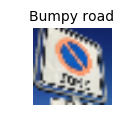

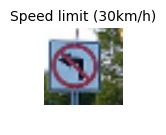

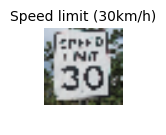

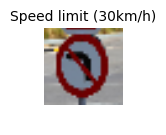

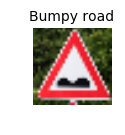

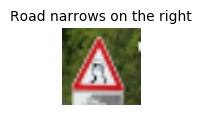

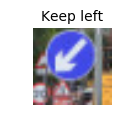

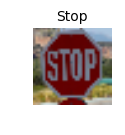

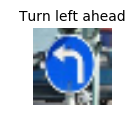

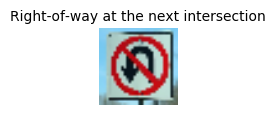

In [24]:
### Inference
feed_dict = {x: X_extra_prep, keep_prob: 1,  k_p_conv: 1}
k_top = 5

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('traffic_model'+model_nbr+'.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    pred_proba = sess.run(softmax_operation, feed_dict=feed_dict)
    prediction = np.argmax(pred_proba, 1)
    # top 5 probabilities
    top_k_values = tf.nn.top_k(softmax_operation, k_top)
    top_k_proba = sess.run([ softmax_operation, top_k_values], feed_dict=feed_dict)
### Feel free to use as many code cells as needed.

#Visualize image with predicted label
print('PREDICTION ON EXTRA DATA \t')
for i in range(len(X_extra)):
    plt.figure(figsize=(1,1))
    img = X_extra[i]
    plt.imshow(img)
    plt.title(sign_names[ prediction[i] ][1], fontsize=10)
    plt.axis('off')
    plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model performs quite badly on the new dataset: it predicts correctly 5 out of 10 signs, hence an accuracy of 50%.

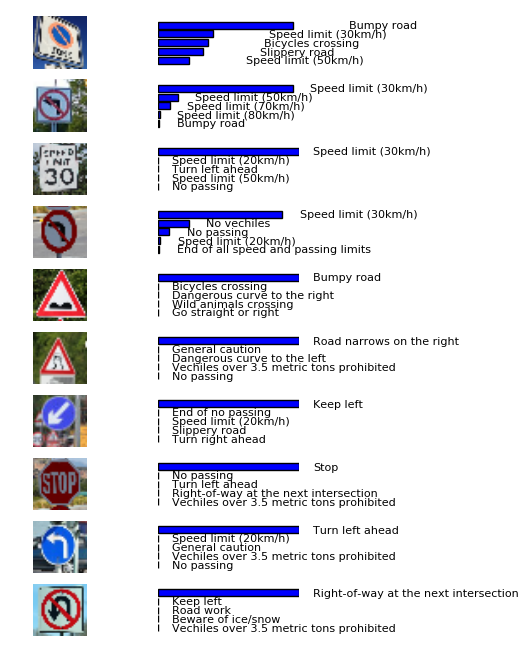

In [25]:
### TOP 5 PROBABILITIES: CERTAINTIES

#initialize subplots
_, ax = plt.subplots( len(file_list), 2, figsize=(4,8))
col_plot = 0
for i in range(len(X_extra)):
    img = X_extra[i]
    ax[i, col_plot].imshow(img)
    ax[i,col_plot].axis('off')
    col_plot += 1
    ax[i, col_plot].barh(-np.arange(k_top),top_k_proba[1][0][i], align='center')
    
    #annotations
    for k in range(k_top):
        text_pos = [top_k_proba[1][0][i][k]+.1, -(k+0.4) ]
        ax[i, col_plot].text( text_pos[0], text_pos[1], sign_names[top_k_proba[1][1][i][k]][1], fontsize=8)
    ax[i,col_plot].axis('off')
    col_plot = 0
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*



**Answer:**

The model is very certain for practically all signs, even for the signs that it misclassifies. For the 1st and 2nd image for example, the 5 top predictions do not include the ground truth.
A few misclassifications are somewhat understandable:
 
* The model mistakens the 6th traffic sign for a "Road Narrows on the right" label instead of "slippery road". However, the predictions of the model is not totally off: there are similar features between the 2 signs: the practically parallel black lines.

However, for other classifications, the model prediction is surprising: in particular the 2nd traffic sign does not show any digits, but the model predicts that it is a sign related to speed limit. Actually, all of its first 5 predictions are related to speed limit.
The first sign has a label that is not represented in the dataset. It is misclassified by the model, but interestingly 4 out the 5 top predictions relates to direction.

## Future work for improving the model

1. Lower the data augmentation with increasing EPOCH.
The data augmentation with rotation and translation in particular, results in black edges/borders that were not present in the original images. At high EPOCHs, it is likely that the model will learn those artefacts.

2. Convert inpout images from RGB to YUV and make gray-scale the 4th color channel of the input.
I did some initial tests with RGB input versus RGB+Grayscale input and found that the accuracy of the latter was about 1pt better.
It is important that the model makes use of the color information to classify the traffic signs.

3. Exploratory: Create a 2nd output for the category of the traffic sign (8 categories)
The categories are Danger warning signs, Priority signs, Prohibitory or restrictive signs, Mandatory signs, Special regulation signs, Information, facilities, or service signs, Direction, position, or indication signs (for the US).

For the loss function, we could use a weighted loss function with higher weight on the loss related to the sign category.

$$loss_{total} = \alpha \times loss_{category} + \eta \times loss_{label}$$

where $ \alpha > \eta $.
This is to help prevent dangerous misclassifications: a stop sign classified as a speed limit sign for example.


### > **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.